# US Stock Market Prediction using data based on a Window
- This notebook includes W&B Tracking of each run


In [1]:
!pip install --upgrade pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 44.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 11.0.0
    Uninstalling pyarrow-11.0.0:
      Successfully uninstalled pyarrow-11.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cubinlinker, which is not installed.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 requires ptxcompiler, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but y

In [2]:
# Importing necessary packages
import os
import numpy as np
import pandas as pd
import logging
import warnings
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import csv
import lightgbm as lgb

from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report, roc_curve, accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
import xgboost as xgb

warnings.filterwarnings('ignore')

# Setting up logging with a FileHandler
log_file_path = 'logger_log.txt'
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

file_handler = logging.FileHandler(log_file_path)
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))

logger = logging.getLogger(__name__)
logger.addHandler(file_handler)

In [3]:
window_back = 2

In [ ]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wab = user_secrets.get_secret("wab")

In [4]:
# Reading the dataset
dataset_path = "/kaggle/input/us-stock-market-2020-to-2024/US Stock Market Dataset.csv"

try:
    # Attempt to read the dataset
    df = pd.read_csv(dataset_path)
    logger.info(f"Dataset loaded successfully from {dataset_path}")
except FileNotFoundError:
    logger.error("Error: Dataset file not found. Please provide the correct file path.")
except Exception as e:
    logger.error(f"An error occurred: {e}")
    
# Rename the first column
df = df.rename(columns={df.columns[0]: 'date_index'})
print(df.columns)

df = df[['date_index','Natural_Gas_Price','Natural_Gas_Vol.','Crude_oil_Price', 'Crude_oil_Vol.', 'Copper_Price' , 'Google_Vol.', 'Nvidia_Price',
       'Nvidia_Vol.', 'Berkshire_Price', 'Berkshire_Vol.', 'Netflix_Price',
       'Netflix_Vol.', 'Amazon_Price', 'Amazon_Vol.', 'Meta_Price',
       'Meta_Vol.', 'Gold_Price', 'Gold_Vol.'    ]]

# Remove all commas
df = df.replace(',','', regex=True)

df['prev_index'] = df['date_index'] + 1
df.head(5)

Index(['date_index', 'Date', 'Natural_Gas_Price', 'Natural_Gas_Vol.',
       'Crude_oil_Price', 'Crude_oil_Vol.', 'Copper_Price', 'Copper_Vol.',
       'Bitcoin_Price', 'Bitcoin_Vol.', 'Platinum_Price', 'Platinum_Vol.',
       'Ethereum_Price', 'Ethereum_Vol.', 'S&P_500_Price', 'Nasdaq_100_Price',
       'Nasdaq_100_Vol.', 'Apple_Price', 'Apple_Vol.', 'Tesla_Price',
       'Tesla_Vol.', 'Microsoft_Price', 'Microsoft_Vol.', 'Silver_Price',
       'Silver_Vol.', 'Google_Price', 'Google_Vol.', 'Nvidia_Price',
       'Nvidia_Vol.', 'Berkshire_Price', 'Berkshire_Vol.', 'Netflix_Price',
       'Netflix_Vol.', 'Amazon_Price', 'Amazon_Vol.', 'Meta_Price',
       'Meta_Vol.', 'Gold_Price', 'Gold_Vol.'],
      dtype='object')


,date_index,Natural_Gas_Price,Natural_Gas_Vol.,Crude_oil_Price,Crude_oil_Vol.,Copper_Price,Google_Vol.,Nvidia_Price,Nvidia_Vol.,Berkshire_Price,Berkshire_Vol.,Netflix_Price,Netflix_Vol.,Amazon_Price,Amazon_Vol.,Meta_Price,Meta_Vol.,Gold_Price,Gold_Vol.,prev_index
0,0,2.079,NaN,72.28,NaN,3.8215,62500000,661.60,47660000,589498,10580,564.64,4030000,171.81,117220000,474.99,84710000,2053.70,NaN,1
1,1,2.050,161340.0,73.82,577940.0,3.8535,37120000,630.27,36020000,581600,9780,567.51,3150000,159.28,66360000,394.78,25140000,2071.10,260920.0,2
2,2,2.100,142860.0,75.85,344490.0,3.9060,71370000,615.27,45070000,578020,9720,564.11,4830000,155.20,49690000,390.14,20010000,2067.40,238370.0,3
3,3,2.077,139750.0,77.82,347240.0,3.9110,33060000,627.74,39600000,584680,9750,562.85,6120000,159.00,42290000,400.06,18610000,2050.90,214590.0,4
4,4,2.490,3590.0,76.78,331930.0,3.8790,27590000,624.65,33900000,578800,13850,575.79,6880000,161.26,42840000,401.02,17790000,2034.90,1780.0,5


In [5]:
def get_prev_pane(df,y,index_col):
    df['prev_index'] = df[index_col] + y
    column_names = df.columns
    df_tmp = pd.merge(df, df, left_on=index_col, right_on='prev_index', how='inner', suffixes=("_"+str(y),''))
    df_tmp = df_tmp.drop(column_names,axis=1)
    df_tmp = df_tmp.drop(['prev_index'+"_"+str(y),index_col+"_"+str(y)],axis=1)
    return df_tmp

In [6]:
for i in range (0,window_back,1):
    prev_df = get_prev_pane(df,i,'date_index')
    if i == 0:
        final_df = prev_df
    else:
        final_df = pd.merge(final_df, prev_df, left_index=True, right_index=True)
    
final_df = final_df.iloc[:-window_back]
final_df

,Natural_Gas_Price_0,Natural_Gas_Vol._0,Crude_oil_Price_0,Crude_oil_Vol._0,Copper_Price_0,Google_Vol._0,Nvidia_Price_0,Nvidia_Vol._0,Berkshire_Price_0,Berkshire_Vol._0,...,Berkshire_Price_1,Berkshire_Vol._1,Netflix_Price_1,Netflix_Vol._1,Amazon_Price_1,Amazon_Vol._1,Meta_Price_1,Meta_Vol._1,Gold_Price_1,Gold_Vol._1
0,2.079,NaN,72.28,NaN,3.8215,62500000,661.60,47660000,589498,10580,...,581600,9780,567.51,3150000,159.28,66360000,394.78,25140000,2071.10,260920.0
1,2.050,161340.0,73.82,577940.0,3.8535,37120000,630.27,36020000,581600,9780,...,578020,9720,564.11,4830000,155.20,49690000,390.14,20010000,2067.40,238370.0
2,2.100,142860.0,75.85,344490.0,3.9060,71370000,615.27,45070000,578020,9720,...,584680,9750,562.85,6120000,159.00,42290000,400.06,18610000,2050.90,214590.0
3,2.077,139750.0,77.82,347240.0,3.9110,33060000,627.74,39600000,584680,9750,...,578800,13850,575.79,6880000,161.26,42840000,401.02,17790000,2034.90,1780.0
4,2.490,3590.0,76.78,331930.0,3.8790,27590000,624.65,33900000,578800,13850,...,582300,10040,570.42,12770000,159.12,51050000,394.14,13160000,2026.60,410.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,2.182,232950.0,58.08,584000.0,2.8610,30750000,62.99,32030000,342855,210,...,340185,140,329.05,4720000,94.16,57140000,218.06,12130000,1560.10,344340.0
1006,2.202,282650.0,59.04,596190.0,2.8135,26260000,61.08,31650000,340185,140,...,343263,280,335.66,4720000,95.05,63500000,218.30,12680000,1554.30,372880.0
1007,2.166,230030.0,59.56,750930.0,2.8020,33230000,60.76,25540000,343263,280,...,339188,190,339.26,7110000,94.60,70240000,215.22,13490000,1560.20,813410.0
1008,2.141,242560.0,59.61,1210000.0,2.8120,35330000,60.09,27720000,339188,190,...,338901,280,330.75,4740000,95.34,82680000,213.06,15110000,1574.30,435870.0


In [7]:
col_names = final_df.columns[1:].tolist()
print(col_names)

# creating a copy of df
df1 = final_df.fillna(0)

#target column name
label_name = 'Natural_Gas_Price_0'

# defining the features and target
X = df1.drop([label_name],axis=1)
y = df1[[label_name]]

# instantiating the scaler
scaler = RobustScaler()

# scaling the continuous featuree
X[col_names] = scaler.fit_transform(X[col_names])

# Get centering and scaling values for each feature
centering = scaler.center_
iqrs  = scaler.scale_

X.head()

['Natural_Gas_Vol._0', 'Crude_oil_Price_0', 'Crude_oil_Vol._0', 'Copper_Price_0', 'Google_Vol._0', 'Nvidia_Price_0', 'Nvidia_Vol._0', 'Berkshire_Price_0', 'Berkshire_Vol._0', 'Netflix_Price_0', 'Netflix_Vol._0', 'Amazon_Price_0', 'Amazon_Vol._0', 'Meta_Price_0', 'Meta_Vol._0', 'Gold_Price_0', 'Gold_Vol._0', 'Natural_Gas_Price_1', 'Natural_Gas_Vol._1', 'Crude_oil_Price_1', 'Crude_oil_Vol._1', 'Copper_Price_1', 'Google_Vol._1', 'Nvidia_Price_1', 'Nvidia_Vol._1', 'Berkshire_Price_1', 'Berkshire_Vol._1', 'Netflix_Price_1', 'Netflix_Vol._1', 'Amazon_Price_1', 'Amazon_Vol._1', 'Meta_Price_1', 'Meta_Vol._1', 'Gold_Price_1', 'Gold_Vol._1']


,Natural_Gas_Vol._0,Crude_oil_Price_0,Crude_oil_Vol._0,Copper_Price_0,Google_Vol._0,Nvidia_Price_0,Nvidia_Vol._0,Berkshire_Price_0,Berkshire_Vol._0,Netflix_Price_0,...,Berkshire_Price_1,Berkshire_Vol._1,Netflix_Price_1,Netflix_Vol._1,Amazon_Price_1,Amazon_Vol._1,Meta_Price_1,Meta_Vol._1,Gold_Price_1,Gold_Vol._1
0,-1.635248,-0.023697,-2.244515,0.022318,2.288272,3.426794,0.172038,1.191226,2.574661,0.775420,...,1.130418,2.333082,0.795268,-0.543030,0.364177,0.035528,1.124899,0.315340,1.363584,0.903157
1,0.470262,0.030367,1.543579,0.060408,0.470546,3.204038,-0.340117,1.131370,2.333333,0.792184,...,1.103342,2.314996,0.775357,-0.135758,0.275970,-0.442089,1.085582,-0.083107,1.342128,0.648261
2,0.229095,0.101632,0.013437,0.122898,2.923545,3.097389,0.058079,1.104239,2.315234,0.772324,...,1.153712,2.324039,0.767978,0.176970,0.358123,-0.654108,1.169639,-0.191845,1.246448,0.379461
3,0.188509,0.170792,0.031461,0.128850,0.179767,3.186050,-0.182598,1.154712,2.324284,0.764964,...,1.109241,3.559910,0.843757,0.361212,0.406983,-0.638350,1.177774,-0.255534,1.153668,-2.026055
4,-1.588398,0.134281,-0.068888,0.090760,-0.211996,3.164080,-0.433396,1.110150,3.561086,0.840550,...,1.135712,2.411454,0.812310,1.789091,0.360718,-0.403123,1.119476,-0.615146,1.105538,-2.041541


In [8]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [9]:
# Defining a dictionary of regression models
regressors = {
    'AdaBoostRegressor': AdaBoostRegressor(),
    'LinearRegression': LinearRegression(n_jobs=-1),
    'KNeighborsRegressor': KNeighborsRegressor(n_jobs=-1),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0),
    'GradientBoostingRegressor': GradientBoostingRegressor(n_estimators=300, max_depth=1, subsample=0.8, max_features=0.2),
    'XGBRegressor': XGBRegressor(objective='reg:squarederror', n_jobs=-1),
    'SVR': SVR(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'BayesianRidge': BayesianRidge()
}

AdaBoostRegressor CV Scores: [-0.08088196 -0.06836052 -0.04943862 -0.06964458 -0.05389146]
AdaBoostRegressor Mean Squared Error (MSE): 0.06842528167493638
AdaBoostRegressor Root Mean Squared Error (RMSE): 0.26158226559714703
AdaBoostRegressor Mean Absolute Error (MAE): 0.1914203293873725
AdaBoostRegressor R^2 Score: 0.983577116111298


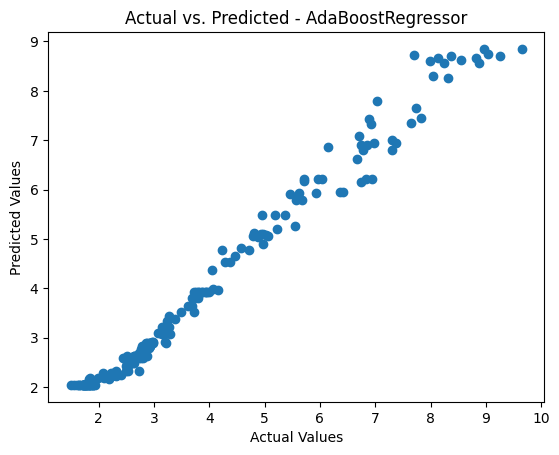

LinearRegression CV Scores: [-0.05274337 -0.05061002 -0.03322353 -0.05100098 -0.0353634 ]
LinearRegression Mean Squared Error (MSE): 0.04535164884025977
LinearRegression Root Mean Squared Error (RMSE): 0.21295926568304036
LinearRegression Mean Absolute Error (MAE): 0.14114233662655765
LinearRegression R^2 Score: 0.9891150632509915


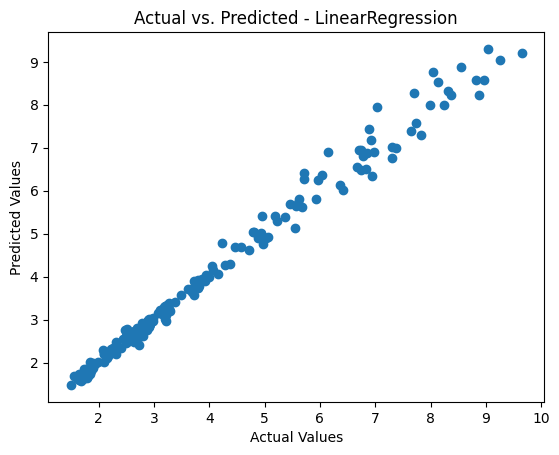

KNeighborsRegressor CV Scores: [-0.26346141 -0.28315597 -0.16613952 -0.24883125 -0.21461072]
KNeighborsRegressor Mean Squared Error (MSE): 0.2840220097029704
KNeighborsRegressor Root Mean Squared Error (RMSE): 0.53293715361473
KNeighborsRegressor Mean Absolute Error (MAE): 0.337319801980198
KNeighborsRegressor R^2 Score: 0.9318313294003405


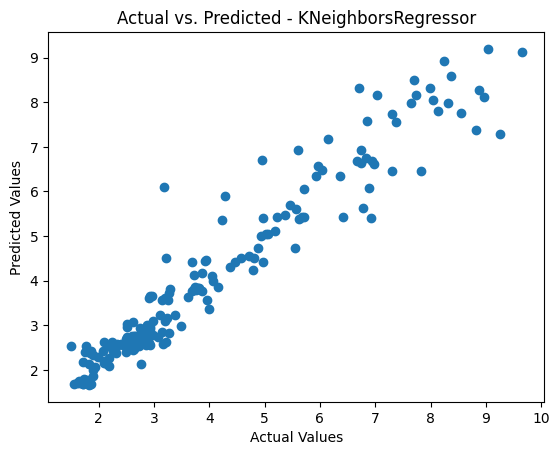

RandomForestRegressor CV Scores: [-0.06877182 -0.05581065 -0.03314629 -0.05664139 -0.04502789]
RandomForestRegressor Mean Squared Error (MSE): 0.05173724370544572
RandomForestRegressor Root Mean Squared Error (RMSE): 0.22745822408839325
RandomForestRegressor Mean Absolute Error (MAE): 0.14498361386138642
RandomForestRegressor R^2 Score: 0.98758244430571


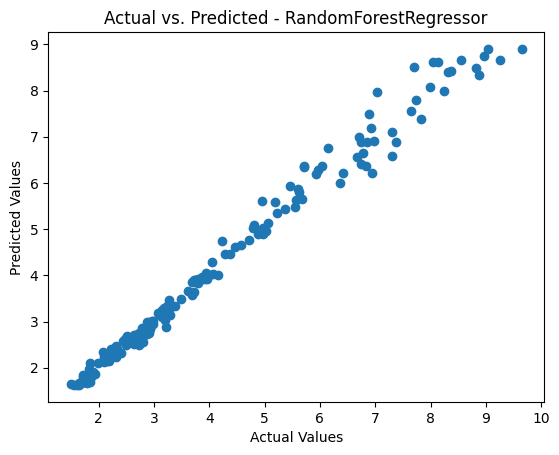

GradientBoostingRegressor CV Scores: [-0.18364463 -0.15109165 -0.1063246  -0.11308708 -0.12033195]
GradientBoostingRegressor Mean Squared Error (MSE): 0.1469024282383375
GradientBoostingRegressor Root Mean Squared Error (RMSE): 0.38327852566813275
GradientBoostingRegressor Mean Absolute Error (MAE): 0.27016747803134306
GradientBoostingRegressor R^2 Score: 0.9647416647345671


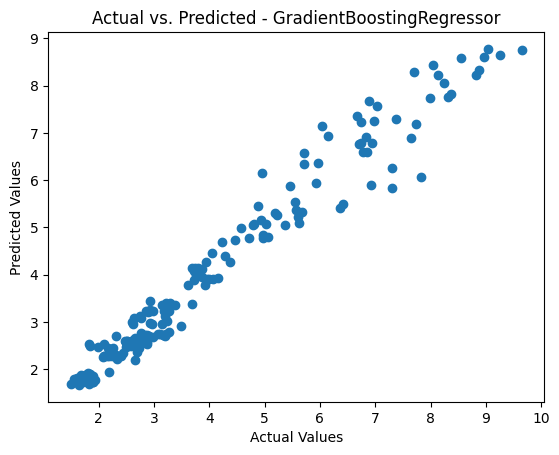

XGBRegressor CV Scores: [-0.08308862 -0.05576426 -0.0371557  -0.06262148 -0.06187395]
XGBRegressor Mean Squared Error (MSE): 0.06074799278048069
XGBRegressor Root Mean Squared Error (RMSE): 0.2464710789940286
XGBRegressor Mean Absolute Error (MAE): 0.15806942561121268
XGBRegressor R^2 Score: 0.9854197570330065


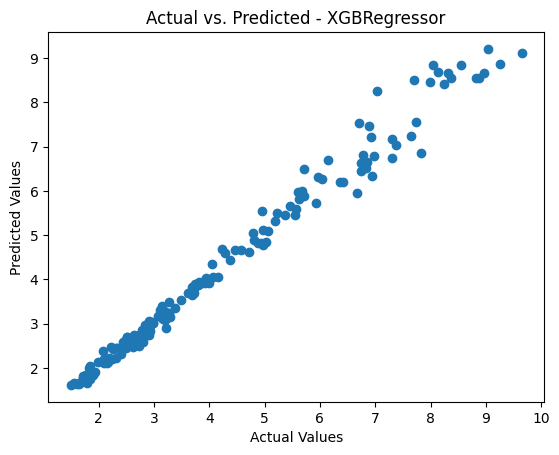

SVR CV Scores: [-0.16761621 -0.3263261  -0.15607272 -0.31055012 -0.26087781]
SVR Mean Squared Error (MSE): 0.1372960205438039
SVR Root Mean Squared Error (RMSE): 0.3705347764296948
SVR Mean Absolute Error (MAE): 0.25008809082254874
SVR R^2 Score: 0.9670473171819234


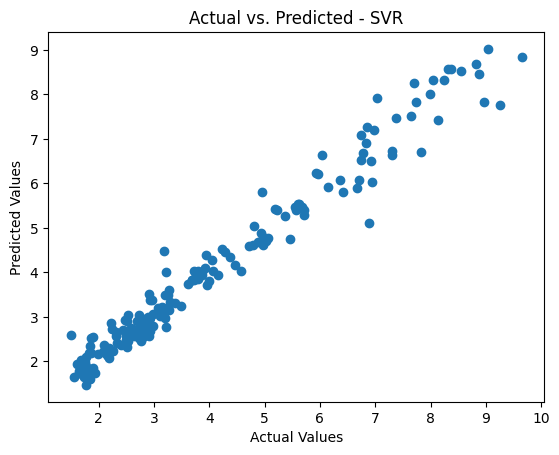

DecisionTreeRegressor CV Scores: [-0.09953761 -0.08542564 -0.05974471 -0.08540635 -0.10224818]
DecisionTreeRegressor Mean Squared Error (MSE): 0.0745980594059406
DecisionTreeRegressor Root Mean Squared Error (RMSE): 0.273126453142021
DecisionTreeRegressor Mean Absolute Error (MAE): 0.18183168316831685
DecisionTreeRegressor R^2 Score: 0.9820955758170448


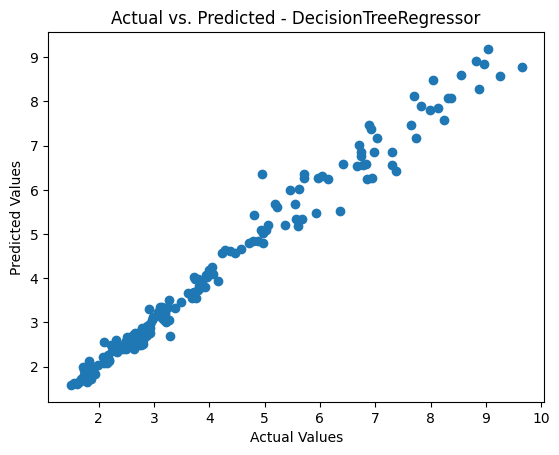

Lasso CV Scores: [-1.54999817 -2.03775498 -1.31523336 -1.45250987 -1.51715177]
Lasso Mean Squared Error (MSE): 1.76717915562183
Lasso Root Mean Squared Error (RMSE): 1.329352908606977
Lasso Mean Absolute Error (MAE): 1.0535981851644436
Lasso R^2 Score: 0.5758559208979885


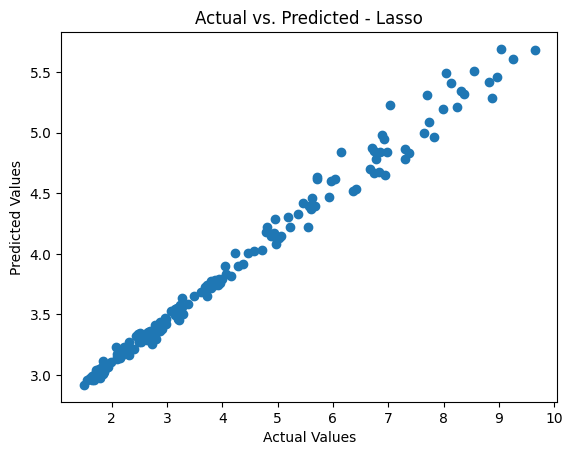

ElasticNet CV Scores: [-1.32253921 -1.67394222 -1.1395156  -1.21676906 -1.29601118]
ElasticNet Mean Squared Error (MSE): 1.4995246317241158
ElasticNet Root Mean Squared Error (RMSE): 1.2245507877275306
ElasticNet Mean Absolute Error (MAE): 0.9659595072320933
ElasticNet R^2 Score: 0.6400961996467138


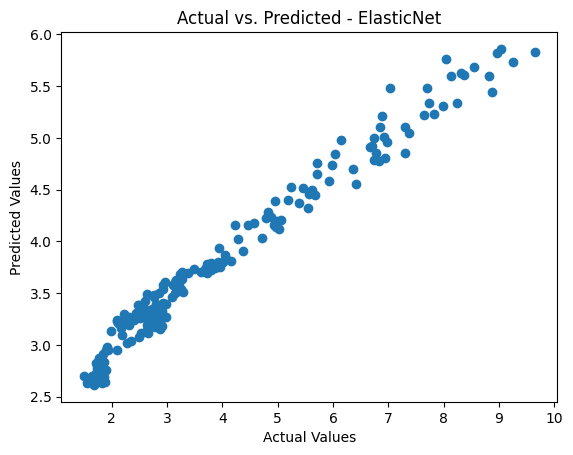

BayesianRidge CV Scores: [-0.05273495 -0.05069935 -0.03288374 -0.04939899 -0.03502589]
BayesianRidge Mean Squared Error (MSE): 0.04522667311324794
BayesianRidge Root Mean Squared Error (RMSE): 0.2126656368886331
BayesianRidge Mean Absolute Error (MAE): 0.14004241258799593
BayesianRidge R^2 Score: 0.9891450589163857


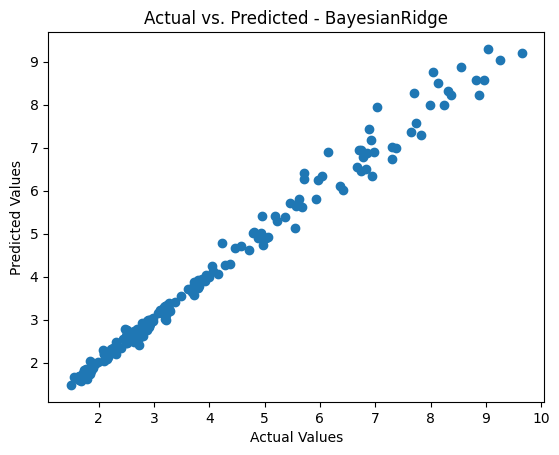

In [10]:
# Improved model evaluation and cross-validation for regression
model_results = []

# Looping through regression models and evaluating their performance
for name, model in regressors.items():
    try:
        logger.info(f"Training and evaluating {name} model.")
        
        # Cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

        # Model training
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        # Evaluation metrics for regression
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)

        model_results.append({'Model': name, 'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R^2': r2, 'CV Scores': cv_scores})
        
        print("=============================================================================")
        print(name, "CV Scores:", cv_scores)
        print(name, "Mean Squared Error (MSE):", mse)
        print(name, "Root Mean Squared Error (RMSE):", rmse)
        print(name, "Mean Absolute Error (MAE):", mae)
        print(name, "R^2 Score:", r2)
        
        logger.info(f"{name} - CV Scores: {cv_scores}")
        logger.info(f"{name} - MSE: {mse}")
        logger.info(f"{name} - RMSE: {rmse}")
        logger.info(f"{name} - MAE: {mae}")
        logger.info(f"{name} - R^2 Score: {r2}")

        # Plotting the actual vs. predicted values
        plt.scatter(y_test, predictions)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Actual vs. Predicted - {name}')
        plt.show()

    except Exception as ex:
        print(ex)
        logger.error(f"An error occurred while processing {name} model: {ex}")


## Model Results Baseline
- MSE is the one that we will use as MSE penalizes larger errors more heavily, which can be important in financial forecasting where large errors may have significant consequences.

In [11]:
df_results = pd.DataFrame(model_results)
df_results

,Model,MSE,RMSE,MAE,R^2,CV Scores
0,AdaBoostRegressor,0.068425,0.261582,0.191420,0.983577,"[-0.08088195550574884, -0.06836052204403154, -..."
1,LinearRegression,0.045352,0.212959,0.141142,0.989115,"[-0.05274337417864865, -0.05061002202978325, -..."
2,KNeighborsRegressor,0.284022,0.532937,0.337320,0.931831,"[-0.2634614135802469, -0.2831559681481482, -0...."
3,RandomForestRegressor,0.051737,0.227458,0.144984,0.987582,"[-0.06877181625679041, -0.055810650370370425, ..."
4,GradientBoostingRegressor,0.146902,0.383279,0.270167,0.964742,"[-0.18364463108450538, -0.15109164883200224, -..."
5,XGBRegressor,0.060748,0.246471,0.158069,0.985420,"[-0.08308861623439583, -0.05576425586931316, -..."
6,SVR,0.137296,0.370535,0.250088,0.967047,"[-0.16761621120164696, -0.32632609783863525, -..."
7,DecisionTreeRegressor,0.074598,0.273126,0.181832,0.982096,"[-0.09953761111111106, -0.08542563580246912, -..."
8,Lasso,1.767179,1.329353,1.053598,0.575856,"[-1.5499981739122153, -2.0377549753908637, -1...."
9,ElasticNet,1.499525,1.224551,0.965960,0.640096,"[-1.3225392142516825, -1.673942215626732, -1.1..."


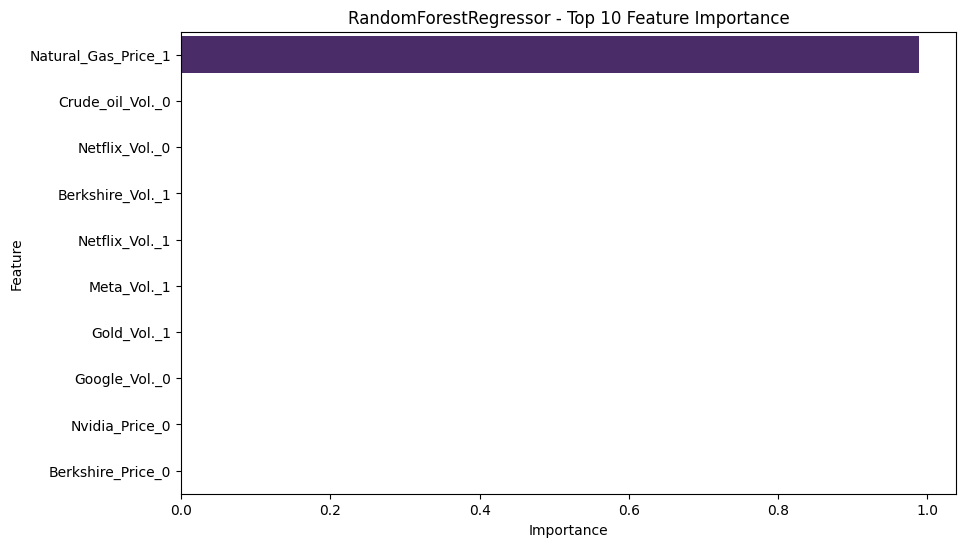

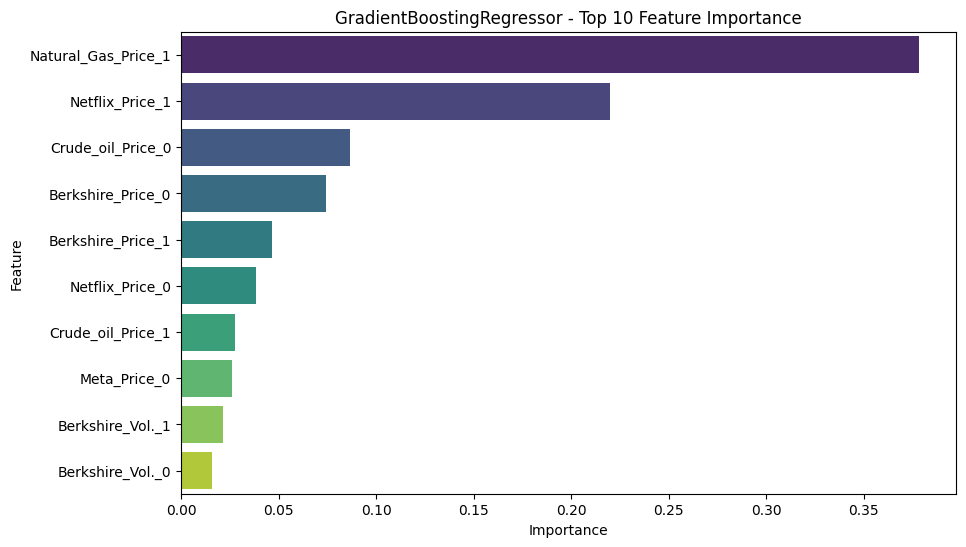

In [12]:
# Feature importance for tree-based models
for name, model in regressors.items():
    if isinstance(model, (RandomForestRegressor, GradientBoostingRegressor)):
        model.fit(X_train, y_train)
        feature_importances = model.feature_importances_
        feature_names = X_train.columns
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
        sorted_df = importance_df.sort_values(by='Importance', ascending=False)
        
        # Display only the top 10 features
        top_10_features = sorted_df.head(10)
        
        # Create seaborn bar plot for the top 10 features
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=top_10_features, palette='viridis')
        plt.title(f"{name} - Top 10 Feature Importance")
        plt.show()


## Big Model

In [ ]:
# Define parameters for LightGBM
params = {
    'objective': 'regression',
    'metric': 'mse',
    'boosting_type': 'gbdt',
    'is_enable_sparse': 'true',        
    'max_drop': 1       
}

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'num_leaves': [50, 100, 150],
    'learning_rate': [0.001,0.01, 0.05, 0.1],
    'feature_fraction': [0.8, 0.9, 1.0],
    'min_child_samples': [10, 20, 30],
    'min_child_weight': [0.001, 0.01, 0.1],
    'max_depth': [100,1000,5000,20000],
    'num_iterations': [100,500,10000],
    'max_bin': [100,500,10000,50000],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5],
    'reg_lambda': [0.0, 0.1, 0.5],
    'gpu_use_dp': ['true','false'],    
    'device': ['gpu']
}

callbacks = [lgb.early_stopping(50)]
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

try:
    # Try using GPU
    params['device'] = 'gpu'    
except lgb.basic.LightGBMError as e:
    # GPU training not supported, fall back to CPU
    del params['device']

# Create a LightGBM model
lgb_model = lgb.LGBMRegressor(verbose=-1)

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(lgb_model, param_grid, scoring='neg_mean_squared_error', cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)
    
# Get the best parameters from the grid search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the final model with the best hyperparameters
final_model = lgb.LGBMRegressor(**base_params, **best_params)
final_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50, verbose=False)

# Make predictions on the test set
y_pred = final_model.predict(X_test, num_iteration=final_model.best_iteration_)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

 # Evaluation metrics for regression
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

model_results.append({'Model': name, 'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R^2': r2, 'CV Scores': cv_scores})

print("=============================================================================")
print(name, "CV Scores:", cv_scores)
print(name, "Mean Squared Error (MSE):", mse)
print(name, "Root Mean Squared Error (RMSE):", rmse)
print(name, "Mean Absolute Error (MAE):", mae)
print(name, "R^2 Score:", r2)

Fitting 5 folds for each of 2519424 candidates, totalling 12597120 fits


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning g

[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time=  13.7s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time=  13.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time=  15.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=0.9; total time=   1.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time=   3.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=0.9; total time=   2.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=0.9; total time=   2.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=0.9; total time=   2.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=0.9; total time=   2.4s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time=  20.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0; total time=   2.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0; total time=   1.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0; total time=   2.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0; total time=   3.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0; total time=   3.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=0.8; total time=   1.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=0.8; total time=   1.7s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=0.8; total time=   2.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=0.9; total time=   2.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=0.9; total time=   1.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=0.9; total time=   1.6s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=0.9; total time=   1.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=0.9; total time=   3.6s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=1.0; total time=   1.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=1.0; total time=   1.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=1.0; total time=   2.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=0.8; total time=   2.3s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=0.8; total time=   2.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=0.8; total time=   1.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=0.8; total time=   1.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=0.8; total time=   1.7s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=0.9; total time=   1.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=0.9; total time=   1.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=0.9; total time=   1.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=0.9; total time=   1.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=0.9; total time=   1.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time=   1.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time=   2.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time=   5.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=0.8; total time=   7.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time=   9.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=0.8; total time=   9.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=0.8; total time=   8.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=0.8; total time=  16.8s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=0.9; total time=   1.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=0.8; total time=   8.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=0.9; total time=   5.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=0.9; total time=   5.6s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=0.9; total time=   5.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=1.0; total time=   1.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=1.0; total time=   1.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=0.9; total time=   6.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=1.0; total time=   2.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=1.0; total time=   2.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8; total time=   1.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8; total time=   1.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9; total time=   1.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8; total time=   2.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9; total time=   1.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9; total time=   1.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9; total time=   1.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time=   1.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9; total time=   2.8s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time=   1.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time=   1.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time=   1.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=   1.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=   2.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=   2.9s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=   3.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=   2.6s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=0.9; total time=   2.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=0.9; total time=   1.5s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=0.9; total time=   1.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=0.9; total time=   2.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=0.9; total time=   2.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0; total time=   1.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0; total time=   1.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0; total time=   1.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0; total time=   1.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=0.8; total time=   1.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=0.8; total time=   1.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=0.9; total time=   1.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=0.9; total time=   1.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=0.8; total time=   2.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=0.9; total time=   1.0s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=0.9; total time=   1.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=0.9; total time=   1.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=1.0; total time=   1.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=1.0; total time=   1.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=1.0; total time=  12.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=0.8; total time=  11.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=1.0; total time=  13.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=1.0; total time=  13.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=0.8; total time=   2.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=0.8; total time=   3.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time=   0.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time=   1.2s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time=   1.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=1.0; total time=   1.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time=   2.4s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time=   2.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=1.0; total time=   1.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=1.0; total time=   1.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.5, subsample=0.9; total time=   1.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.5, subsample=0.9; total time=   1.0s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.5, subsample=0.9; total time=   2.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.5, subsample=0.9; total time=   1.0s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.5, subsample=0.9; total time=   1.7s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=50, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time=   2.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time=   3.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time=   2.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time=   4.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time=   4.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.0, subsample=0.9; total time=   2.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.0, subsample=0.9; total time=   2.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.0, subsample=0.9; total time=   2.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.0, subsample=0.9; total time=   3.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.0, subsample=0.9; total time=   3.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0; total time=   2.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0; total time=   4.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0; total time=   3.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0; total time=   3.2s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0; total time=   3.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.1, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.1, subsample=0.8; total time=   2.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.1, subsample=0.8; total time=   2.7s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.1, subsample=0.8; total time=   1.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.1, subsample=0.8; total time=   2.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.1, subsample=0.9; total time=   1.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.1, subsample=0.9; total time=   2.1s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.1, subsample=0.9; total time=   2.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.1, subsample=0.9; total time=   2.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.1, subsample=0.9; total time=   3.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.1, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.1, subsample=1.0; total time=   2.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.1, subsample=1.0; total time=   2.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.1, subsample=1.0; total time=   1.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.5, subsample=0.8; total time=   1.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.5, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.1, subsample=1.0; total time=   2.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.5, subsample=0.8; total time=   1.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.5, subsample=0.8; total time=   2.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.5, subsample=0.8; total time=   2.6s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.5, subsample=0.9; total time=   2.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.5, subsample=0.9; total time=   1.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.5, subsample=0.9; total time=   2.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.5, subsample=0.9; total time=   1.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.5, subsample=0.9; total time=   2.1s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time=   2.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time=   1.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time=   1.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time=   1.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time=   1.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.0, subsample=0.8; total time=   2.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.0, subsample=0.8; total time=   2.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.0, subsample=0.8; total time=   2.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.0, subsample=0.8; total time=   1.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.0, subsample=0.8; total time=   3.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.0, subsample=0.9; total time=   3.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.0, subsample=0.9; total time=   2.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.0, subsample=0.9; total time=   2.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.0, subsample=0.9; total time=   2.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.0, subsample=0.9; total time=   1.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.0, subsample=1.0; total time=   2.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.0, subsample=1.0; total time=   3.5s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.0, subsample=1.0; total time=   2.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.0, subsample=1.0; total time=   4.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.0, subsample=1.0; total time=   2.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8; total time=   2.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8; total time=   2.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9; total time=   1.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9; total time=   1.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8; total time=   3.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8; total time=   2.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9; total time=   2.2s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9; total time=   1.8s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9; total time=   2.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time=   1.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time=   1.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time=   2.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=   1.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=   1.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=   2.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=   1.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.5, subsample=0.9; total time=   1.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.5, subsample=0.9; total time=   1.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.5, subsample=0.9; total time=   1.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.5, subsample=0.9; total time=   1.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.5, subsample=0.9; total time=   2.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0; total time=   2.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0; total time=   2.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0; total time=   1.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0; total time=   1.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.0, subsample=0.8; total time=   1.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0; total time=   2.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.0, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.0, subsample=0.8; total time=   2.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.0, subsample=0.8; total time=   1.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.0, subsample=0.8; total time=   2.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.0, subsample=0.9; total time=   1.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.0, subsample=0.9; total time=   1.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.0, subsample=0.9; total time=   1.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.0, subsample=0.9; total time=   1.2s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.0, subsample=0.9; total time=   1.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.0, subsample=1.0; total time=   1.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.0, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.0, subsample=1.0; total time=   2.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.0, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.0, subsample=1.0; total time=   1.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.1, subsample=0.8; total time=   1.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.1, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.1, subsample=0.8; total time=   1.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.1, subsample=0.8; total time=   1.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time=   1.1s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time=   1.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.1, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time=   0.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time=   1.3s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time=   2.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.1, subsample=1.0; total time=   1.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.1, subsample=1.0; total time=   1.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.1, subsample=1.0; total time=   1.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.1, subsample=1.0; total time=   1.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.5, subsample=0.9; total time=   0.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.5, subsample=0.9; total time=   1.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.5, subsample=0.9; total time=   0.9s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.5, subsample=0.9; total time=   1.6s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.5, subsample=0.9; total time=   1.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time=   1.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time=   2.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time=   2.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time=   4.0s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.0, subsample=0.9; total time=   2.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time=   3.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.0, subsample=0.9; total time=   1.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.0, subsample=0.9; total time=   2.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0; total time=   1.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.0, subsample=0.9; total time=   2.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0; total time=   1.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.0, subsample=0.9; total time=   8.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0; total time=   2.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0; total time=   2.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0; total time=   4.6s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.1, subsample=0.8; total time=   1.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.1, subsample=0.8; total time=   2.3s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.1, subsample=0.8; total time=   2.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.1, subsample=0.8; total time=   1.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.1, subsample=0.8; total time=   2.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.1, subsample=0.9; total time=   2.9s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.1, subsample=0.9; total time=   2.4s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.1, subsample=0.9; total time=   2.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.1, subsample=0.9; total time=   3.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.1, subsample=0.9; total time=   1.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.1, subsample=1.0; total time=   1.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.1, subsample=1.0; total time=   2.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.1, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.1, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.1, subsample=1.0; total time=   3.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.5, subsample=0.8; total time=   0.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.5, subsample=0.8; total time=   1.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.5, subsample=0.8; total time=   1.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.5, subsample=0.9; total time=   1.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.5, subsample=0.9; total time=   1.2s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.5, subsample=0.8; total time=   2.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.5, subsample=0.8; total time=   3.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.5, subsample=0.9; total time=   1.2s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time=   1.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.5, subsample=0.9; total time=   2.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time=   0.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time=   2.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time=   3.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.0, reg_lambda=0.5, subsample=0.9; total time=   5.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.0, subsample=0.8; total time=   1.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.0, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.0, subsample=0.8; total time=   1.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.0, subsample=0.8; total time=   1.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.0, subsample=0.8; total time=   2.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.0, subsample=0.9; total time=   1.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.0, subsample=0.9; total time=   1.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.0, subsample=0.9; total time=   1.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.0, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.0, subsample=0.9; total time=   4.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.0, subsample=1.0; total time=   1.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.0, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.0, subsample=0.9; total time=   6.6s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.0, subsample=1.0; total time=   1.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.0, subsample=1.0; total time=   2.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8; total time=   1.7s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8; total time=   1.3s

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8; total time=   2.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9; total time=   1.7s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9; total time=   2.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9; total time=   1.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9; total time=   1.3s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9; total time=   1.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time=   1.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time=   2.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time=   1.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time=   1.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time=   2.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=   1.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=   2.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=   1.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.5, subsample=0.9; total time=   1.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.5, subsample=0.9; total time=   1.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.5, subsample=0.9; total time=   1.2s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.5, subsample=0.9; total time=   1.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=   2.9s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.5, subsample=0.9; total time=   1.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0; total time=   1.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0; total time=   2.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0; total time=   1.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.0, subsample=0.8; total time=   1.7s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.0, subsample=0.8; total time=   1.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.0, subsample=0.8; total time=   6.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.0, subsample=0.8; total time=   8.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.0, subsample=0.8; total time=  11.0s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.0, subsample=0.9; total time=   4.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.0, subsample=0.9; total time=   1.6s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.0, subsample=0.9; total time=   9.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.0, subsample=0.9; total time=   0.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.0, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.0, subsample=1.0; total time=   1.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.0, subsample=0.9; total time=   1.8s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.0, subsample=1.0; total time=   1.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.0, subsample=1.0; total time=   1.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.0, subsample=1.0; total time=   1.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.1, subsample=0.8; total time=   1.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.1, subsample=0.8; total time=   2.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.1, subsample=0.8; total time=   1.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time=   1.0s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.1, subsample=0.8; total time=   1.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time=   1.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time=   1.4s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time=   1.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time=   1.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.1, subsample=1.0; total time=   0.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.1, subsample=1.0; total time=   1.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.1, subsample=1.0; total time=   1.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.1, subsample=1.0; total time=   1.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.5, subsample=0.9; total time=   1.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.5, subsample=0.9; total time=   1.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.5, subsample=0.9; total time=   1.7s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.5, subsample=0.9; total time=   0.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.5, subsample=0.9; total time=   1.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=100, num_leaves=150, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time=   9.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time=  11.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time=   9.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=0.9; total time=   9.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=0.9; total time=   9.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time=  28.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=0.9; total time=   9.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time=  35.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=0.9; total time=  11.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0; total time=  14.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0; total time=  10.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0; total time=  10.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=0.9; total time=  25.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0; total time=  10.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0; total time=  10.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=0.8; total time=   7.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=0.8; total time=   7.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=0.8; total time=   9.0s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=0.8; total time=   7.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=0.8; total time=  10.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=0.9; total time=   8.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=0.9; total time=  11.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=0.9; total time=  14.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=0.9; total time=   9.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=0.9; total time=   8.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=1.0; total time=   7.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=1.0; total time=  12.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=1.0; total time=   8.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=1.0; total time=  11.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=1.0; total time=   7.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=0.8; total time=   5.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=0.8; total time=   6.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=0.8; total time=  14.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=0.8; total time=  16.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=0.8; total time=  13.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=0.9; total time=  14.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=0.9; total time=  17.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=0.9; total time=  11.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=0.9; total time=  16.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time=   6.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=0.9; total time=  17.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time=   6.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time=   5.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time=   5.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time=   7.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=0.8; total time=   8.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=0.8; total time=  10.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=0.8; total time=  11.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=0.8; total time=  10.9s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=0.8; total time=   7.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=0.9; total time=   6.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=0.9; total time=   6.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=0.9; total time=   7.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=0.9; total time=  11.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=0.9; total time=   8.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=1.0; total time=   6.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=1.0; total time=  10.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=1.0; total time=   6.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=1.0; total time=   6.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8; total time=   6.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=1.0; total time=  12.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8; total time=   6.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8; total time=  11.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8; total time=   6.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8; total time=   6.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9; total time=   9.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9; total time=   5.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9; total time=   7.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9; total time=  11.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9; total time=   6.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time=   5.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time=   6.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time=   7.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time=   6.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=   5.2s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time=   6.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=   5.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=   5.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=   8.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=   9.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=0.9; total time=   4.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=0.9; total time=   5.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=0.9; total time=   5.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=0.9; total time=   5.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=0.9; total time=  10.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0; total time=   6.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0; total time=   5.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0; total time=   6.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0; total time=   6.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0; total time=   7.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=0.8; total time=   8.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=0.8; total time=   5.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=0.8; total time=   4.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=0.8; total time=   9.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=0.8; total time=   5.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=0.9; total time=   4.8s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=0.9; total time=   4.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=0.9; total time=   6.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=1.0; total time=   6.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=0.9; total time=  11.8s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=0.9; total time=  14.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=1.0; total time=   7.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=1.0; total time=   7.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=1.0; total time=   5.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=1.0; total time=   6.2s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=0.8; total time=   4.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=0.8; total time=   3.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=0.8; total time=   8.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=0.8; total time=   3.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=0.8; total time=   5.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time=   4.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time=   5.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time=   5.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time=   5.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=1.0; total time=   5.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=1.0; total time=   7.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=1.0; total time=   5.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time=  11.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=1.0; total time=   5.1s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   3.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=1.0; total time=   6.1s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   4.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   4.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   6.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   6.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.5, subsample=0.9; total time=   5.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.5, subsample=0.9; total time=   4.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.5, subsample=0.9; total time=   3.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.5, subsample=0.9; total time=   6.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   4.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.5, subsample=0.9; total time=   8.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   4.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   4.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   5.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=50, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   6.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time=  11.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time=  14.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time=  10.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time=  20.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.0, subsample=0.9; total time=   9.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time=  18.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.0, subsample=0.9; total time=  21.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.0, subsample=0.9; total time=  25.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0; total time=  11.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0; total time=  11.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.0, subsample=0.9; total time=  26.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.0, subsample=0.9; total time=  21.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.1, subsample=0.8; total time=   8.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0; total time=  10.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0; total time=  11.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0; total time=  12.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.1, subsample=0.8; total time=   7.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.1, subsample=0.8; total time=   7.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.1, subsample=0.8; total time=   9.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.1, subsample=0.8; total time=  12.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.1, subsample=0.9; total time=  15.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.1, subsample=0.9; total time=  17.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.1, subsample=0.9; total time=  12.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.1, subsample=0.9; total time=   8.7s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.1, subsample=0.9; total time=  19.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.1, subsample=1.0; total time=   8.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.1, subsample=1.0; total time=   8.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.1, subsample=1.0; total time=   8.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.1, subsample=1.0; total time=   9.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.5, subsample=0.8; total time=   6.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.1, subsample=1.0; total time=   7.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.5, subsample=0.8; total time=   7.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.5, subsample=0.8; total time=   6.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.5, subsample=0.8; total time=   7.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.5, subsample=0.8; total time=  11.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.5, subsample=0.9; total time=   5.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.5, subsample=0.9; total time=   5.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.5, subsample=0.9; total time=   9.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.5, subsample=0.9; total time=   5.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time=   5.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.5, subsample=0.9; total time=   8.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time=   4.6s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time=   8.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time=   4.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time=   7.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.0, subsample=0.8; total time=   5.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.0, subsample=0.8; total time=   7.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.0, subsample=0.8; total time=   9.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.0, subsample=0.8; total time=  11.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.0, subsample=0.8; total time=   9.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.0, subsample=0.9; total time=   8.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.0, subsample=0.9; total time=   7.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.0, subsample=0.9; total time=   6.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.0, subsample=0.9; total time=   6.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.0, subsample=1.0; total time=   7.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.0, subsample=1.0; total time=  13.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.0, subsample=0.9; total time=  19.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.0, subsample=1.0; total time=  13.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8; total time=   5.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8; total time=   6.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.0, subsample=1.0; total time=  23.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8; total time=   9.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8; total time=   5.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.0, subsample=1.0; total time=  18.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8; total time=   7.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9; total time=   6.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9; total time=   6.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9; total time=   7.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9; total time=   5.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time=   6.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time=   5.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9; total time=  19.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time=  17.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time=  11.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time=  10.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=   6.5s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=   8.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=   6.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=   5.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.5, subsample=0.9; total time=   4.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.5, subsample=0.9; total time=   6.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=   8.0s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.5, subsample=0.9; total time=   5.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.5, subsample=0.9; total time=   5.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.5, subsample=0.9; total time=   5.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0; total time=   8.5s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0; total time=   8.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0; total time=   6.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0; total time=   6.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.0, subsample=0.8; total time=   8.9s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0; total time=  10.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.0, subsample=0.8; total time=  12.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.0, subsample=0.8; total time=   5.0s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.0, subsample=0.8; total time=   5.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.0, subsample=0.8; total time=  13.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.0, subsample=0.9; total time=   5.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.0, subsample=0.9; total time=   5.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.0, subsample=0.9; total time=   6.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.0, subsample=0.9; total time=   8.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.0, subsample=0.9; total time=   7.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.0, subsample=1.0; total time=   4.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.0, subsample=1.0; total time=   4.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.0, subsample=1.0; total time=  16.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.0, subsample=1.0; total time=  11.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.1, subsample=0.8; total time=   5.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.1, subsample=0.8; total time=  13.2s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.1, subsample=0.8; total time=   4.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.0, subsample=1.0; total time=  18.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.1, subsample=0.8; total time=   4.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.1, subsample=0.8; total time=   5.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time=   7.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time=   5.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time=   8.6s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time=   4.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time=   5.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.1, subsample=1.0; total time=   5.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.1, subsample=1.0; total time=   5.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.1, subsample=1.0; total time=   6.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.1, subsample=1.0; total time=   6.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   5.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.1, subsample=1.0; total time=   6.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   5.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   9.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   8.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.5, subsample=0.9; total time=   9.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=  10.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.5, subsample=0.9; total time=   4.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.5, subsample=0.9; total time=   4.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.5, subsample=0.9; total time=   9.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   4.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   4.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   4.3s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   7.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.5, subsample=0.9; total time=  13.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=100, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   4.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time=  11.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time=  11.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time=  11.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time=  14.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time=  10.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.0, subsample=0.9; total time=  11.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.0, subsample=0.9; total time=  11.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.0, subsample=0.9; total time=  10.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.0, subsample=0.9; total time=  10.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.0, subsample=0.9; total time=  23.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0; total time=  11.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0; total time=  10.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0; total time=  15.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0; total time=  13.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.1, subsample=0.8; total time=  11.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.1, subsample=0.8; total time=   8.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.1, subsample=0.8; total time=  11.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.1, subsample=0.8; total time=  15.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.1, subsample=0.9; total time=  12.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.1, subsample=0.8; total time=  20.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0; total time=  35.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.1, subsample=0.9; total time=   9.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.1, subsample=0.9; total time=  10.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.1, subsample=0.9; total time=  13.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.1, subsample=0.9; total time=  12.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.1, subsample=1.0; total time=   8.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.1, subsample=1.0; total time=   7.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.1, subsample=1.0; total time=   7.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.1, subsample=1.0; total time=   7.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.5, subsample=0.8; total time=   5.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.1, subsample=1.0; total time=  14.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.5, subsample=0.8; total time=   5.5s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.5, subsample=0.8; total time=   5.8s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.5, subsample=0.8; total time=   7.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.5, subsample=0.8; total time=  11.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.5, subsample=0.9; total time=   6.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.5, subsample=0.9; total time=   7.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.5, subsample=0.9; total time=   7.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.5, subsample=0.9; total time=   6.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time=   5.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.5, subsample=0.9; total time=   7.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time=  13.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time=   7.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time=  13.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time=  13.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.0, subsample=0.8; total time=   6.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.0, subsample=0.8; total time=   6.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.0, subsample=0.8; total time=  10.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.0, subsample=0.8; total time=   7.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.0, subsample=0.8; total time=  14.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.0, subsample=0.9; total time=   8.8s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.0, subsample=0.9; total time=   8.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.0, subsample=0.9; total time=   7.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.0, subsample=0.9; total time=   8.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.0, subsample=1.0; total time=   5.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.0, subsample=1.0; total time=   6.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.0, subsample=1.0; total time=   6.5s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.0, subsample=0.9; total time=  13.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.0, subsample=1.0; total time=   6.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.0, subsample=1.0; total time=  17.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8; total time=   6.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8; total time=   7.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8; total time=   8.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8; total time=   6.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8; total time=   5.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9; total time=   8.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9; total time=  10.0s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9; total time=   7.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9; total time=   5.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time=   5.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time=   6.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9; total time=  20.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time=   6.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time=   8.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time=  12.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=  11.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=   4.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=  13.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=  11.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.5, subsample=0.9; total time=   5.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=  16.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.5, subsample=0.9; total time=   8.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.5, subsample=0.9; total time=   5.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.5, subsample=0.9; total time=   5.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0; total time=   5.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.5, subsample=0.9; total time=  11.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0; total time=   5.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0; total time=   5.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.0, subsample=0.8; total time=   4.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0; total time=   9.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0; total time=  14.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.0, subsample=0.8; total time=   6.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.0, subsample=0.8; total time=   9.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.0, subsample=0.8; total time=   5.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.0, subsample=0.8; total time=   7.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.0, subsample=0.9; total time=   5.2s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.0, subsample=0.9; total time=   4.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.0, subsample=0.9; total time=   8.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.0, subsample=0.9; total time=   4.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.0, subsample=1.0; total time=   4.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.0, subsample=1.0; total time=   4.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.0, subsample=1.0; total time=   6.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.0, subsample=0.9; total time=  11.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.0, subsample=1.0; total time=   4.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.0, subsample=1.0; total time=   7.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.1, subsample=0.8; total time=   8.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.1, subsample=0.8; total time=   6.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.1, subsample=0.8; total time=   6.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.1, subsample=0.8; total time=   4.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time=   3.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time=   4.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time=   5.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time=   4.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time=   4.6s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.1, subsample=0.8; total time=  18.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.1, subsample=1.0; total time=   5.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.1, subsample=1.0; total time=   7.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.1, subsample=1.0; total time=   5.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.1, subsample=1.0; total time=   3.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   5.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   4.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   4.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.1, subsample=1.0; total time=  12.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   3.9s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.5, subsample=0.9; total time=   4.1s
[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   5.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.5, subsample=0.9; total time=   4.7s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.5, subsample=0.9; total time=   4.0s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.5, subsample=0.9; total time=   4.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   4.5s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   4.1s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   3.8s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.5, subsample=0.9; total time=  13.4s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   8.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=500, num_leaves=150, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   4.3s


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time= 4.7min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time= 4.8min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time= 4.8min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time= 5.0min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=0.9; total time= 4.1min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time= 4.6min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=0.9; total time= 4.6min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=0.9; total time= 5.4min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=0.9; total time= 5.1min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0; total time= 4.8min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=0.9; total time= 5.0min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0; total time= 4.1min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0; total time= 4.5min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=0.8; total time= 4.3min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0; total time= 4.9min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0; total time= 5.3min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=0.8; total time= 4.2min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=0.8; total time= 4.7min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=0.8; total time= 3.9min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=0.8; total time= 4.4min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=0.9; total time= 4.8min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=0.9; total time= 4.8min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=0.9; total time= 5.2min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=0.9; total time= 6.0min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=0.9; total time= 4.7min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=1.0; total time= 5.0min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=1.0; total time= 4.6min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=1.0; total time= 4.2min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=1.0; total time= 4.4min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.1, subsample=1.0; total time= 4.1min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=0.8; total time= 5.2min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=0.8; total time= 5.0min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=0.8; total time= 3.9min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=0.8; total time= 4.7min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=0.8; total time= 4.2min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=0.9; total time= 4.4min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=0.9; total time= 4.2min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=0.9; total time= 4.8min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=0.9; total time= 4.1min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=0.9; total time= 4.9min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time= 4.2min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time= 4.4min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time= 4.1min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time= 4.4min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time= 5.0min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=0.8; total time= 3.6min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=0.8; total time= 3.9min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=0.8; total time= 3.5min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=0.8; total time= 3.9min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=0.8; total time= 3.7min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=0.9; total time= 3.7min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=0.9; total time= 3.2min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=0.9; total time= 3.4min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=0.9; total time= 3.8min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=0.9; total time= 4.2min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=1.0; total time= 3.6min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=1.0; total time= 4.0min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=1.0; total time= 3.6min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=1.0; total time= 4.4min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.0, subsample=1.0; total time= 4.0min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8; total time= 3.5min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8; total time= 3.9min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8; total time= 3.7min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8; total time= 3.8min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9; total time= 3.5min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8; total time= 4.6min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9; total time= 4.3min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9; total time= 4.8min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9; total time= 4.0min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9; total time= 3.7min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time= 3.7min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time= 3.4min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time= 3.9min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time= 3.9min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time= 3.2min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time= 4.7min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time= 3.6min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time= 3.8min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time= 3.9min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time= 4.1min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=0.9; total time= 3.4min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=0.9; total time= 3.5min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=0.9; total time= 4.4min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=0.9; total time= 4.6min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=0.9; total time= 3.8min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0; total time= 3.7min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0; total time= 3.6min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0; total time= 3.7min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0; total time= 4.1min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=0.8; total time= 3.4min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0; total time= 4.0min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=0.8; total time= 2.7min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=0.8; total time= 3.0min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=0.8; total time= 2.9min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=0.8; total time= 3.7min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=0.9; total time= 2.9min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=0.9; total time= 3.3min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=0.9; total time= 2.6min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=0.9; total time= 3.2min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=1.0; total time= 2.6min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=0.9; total time= 2.9min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=1.0; total time= 2.5min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=1.0; total time= 3.0min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=1.0; total time= 2.8min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=1.0; total time= 3.0min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=0.8; total time= 3.1min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=0.8; total time= 2.5min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=0.8; total time= 2.6min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=0.8; total time= 3.1min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=0.8; total time= 2.8min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time= 2.9min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time= 2.7min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time= 2.8min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time= 3.1min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time= 2.8min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=1.0; total time= 2.4min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=1.0; total time= 2.9min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=1.0; total time= 2.9min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=1.0; total time= 3.4min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.5, reg_lambda=0.1, subsample=1.0; total time= 3.4min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END colsample_bytree=0.8, device=gpu, feature_fraction=0.8, gpu_use_dp=true, learning_rate=0.001, max_bin=100, max_depth=100, min_child_samples=10, min_child_weight=0.001, num_iterations=10000, num_leaves=50, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time= 2.9min


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [ ]:
# Save log messages to a file
# File handling: close the FileHandler
file_handler.close()
logger.removeHandler(file_handler)